In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prophet as pp
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Importing plotly failed. Interactive plots will not work.


Libraries imported successfully!


In [2]:
try:
    # Create a dummy DataFrame 
    num_entries = 365 * 2 # Two years of daily data
    start_date = pd.to_datetime('2022-01-01')
    dates = pd.date_range(start=start_date, periods=num_entries, freq='D')

    job_roles_list = ['Data Scientist', 'Software Engineer', 'Product Manager', 'UX Designer',
                      'DevOps Engineer', 'Machine Learning Engineer', 'Cloud Architect']
    
    # Simulate varying demand over time and for different roles
    demand_counts = np.random.randint(50, 200, num_entries) + \
                    np.sin(np.arange(num_entries) / 30) * 50 + \
                    np.random.normal(0, 10, num_entries) # Add seasonality and noise

    job_descriptions_templates = [
        "Requires strong Python skills, machine learning, deep learning, and data analysis. Experience with TensorFlow/PyTorch.",
        "Develop scalable software solutions, experience with Java, Spring Boot, and cloud platforms like AWS/Azure.",
        "Define product roadmap, user stories, collaborate with engineering and design teams. Strong communication skills.",
        "Design user interfaces, conduct user research, proficiency in Figma and Adobe XD. Focus on user-centered design.",
        "Manage CI/CD pipelines, infrastructure as code (Terraform), and containerization (Docker, Kubernetes).",
        "Build and deploy ML models, MLOps, model monitoring, and expertise in Python/R for advanced analytics.",
        "Design and implement cloud solutions, expertise in AWS/Azure/GCP, network architecture, and security best practices."
    ]

    # Assign job roles and descriptions randomly or with some pattern
    job_roles = np.random.choice(job_roles_list, num_entries)
    job_descriptions = [np.random.choice(job_descriptions_templates) for _ in range(num_entries)]

    data = pd.DataFrame({
        'date': dates,
        'job_role': job_roles,
        'demand_count': demand_counts,
        'job_description': job_descriptions
    })
    
    # Ensure 'date' is datetime type
    data['date'] = pd.to_datetime(data['date'])

    print("Dummy dataset created successfully. Remember to replace this with your actual data!")
    print("\nFirst 5 rows of the dataset:")
    print(data.head())

except Exception as e:
    print(f"An error occurred during data loading: {e}")
    print("Please ensure your CSV file is correctly formatted and accessible, or check the dummy data creation logic.")

Dummy dataset created successfully. Remember to replace this with your actual data!

First 5 rows of the dataset:
        date                   job_role  demand_count  \
0 2022-01-01          Software Engineer    181.233521   
1 2022-01-02  Machine Learning Engineer     55.488833   
2 2022-01-03            Product Manager    107.581214   
3 2022-01-04                UX Designer     88.100158   
4 2022-01-05                UX Designer    144.598388   

                                     job_description  
0  Define product roadmap, user stories, collabor...  
1  Build and deploy ML models, MLOps, model monit...  
2  Define product roadmap, user stories, collabor...  
3  Requires strong Python skills, machine learnin...  
4  Build and deploy ML models, MLOps, model monit...  


In [9]:

data['date'] = pd.to_datetime(data['date'])

# For forecasting, Prophet requires a 'ds' (datestamp) and 'y' (value) column.
# We'll sum the 'demand_count' for each month to get a monthly aggregate.
time_series_data = data.groupby(pd.Grouper(key='date', freq='M'))['demand_count'].sum().reset_index()

# Rename columns to 'ds' (datestamp) and 'y' (value to forecast) for Prophet
time_series_data.rename(columns={'date': 'ds', 'demand_count': 'y'}, inplace=True)

print("Time series data prepared for Prophet:")
print(time_series_data.head())

Time series data prepared for Prophet:
          ds            y
0 2022-01-31  4390.009476
1 2022-02-28  4793.497277
2 2022-03-31  5202.399280
3 2022-04-30  3263.143262
4 2022-05-31  2010.977108


In [4]:

model = pp.Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False, 
    daily_seasonality=False   
)

model.fit(time_series_data)

# Create a future dataframe for predictions.
future = model.make_future_dataframe(periods=12, freq='M')

# Make predictions on the future dataframe
forecast = model.predict(future)

print("Prophet forecast generated. First 5 rows of forecast:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

17:11:27 - cmdstanpy - INFO - Chain [1] start processing
17:11:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet forecast generated. First 5 rows of forecast:
          ds         yhat   yhat_lower   yhat_upper
0 2022-01-31  4389.997078  4389.997078  4389.997078
1 2022-02-28  4793.475898  4793.475898  4793.475898
2 2022-03-31  5202.402785  5202.402785  5202.402785
3 2022-04-30  3263.170444  3263.170444  3263.170445
4 2022-05-31  2010.979872  2010.979872  2010.979873


<Figure size 1200x600 with 0 Axes>

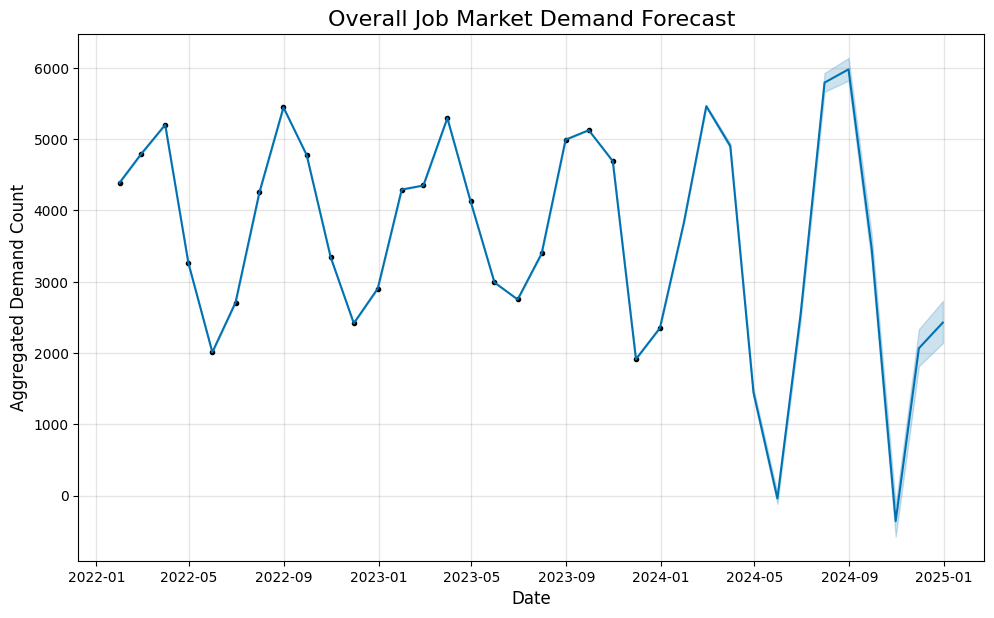

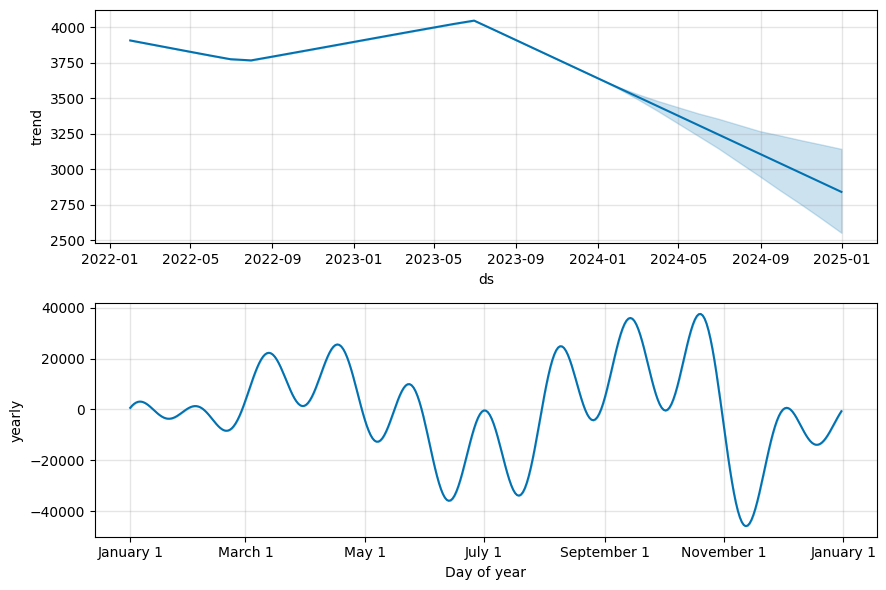

In [5]:

plt.figure(figsize=(12, 6))
fig = model.plot(forecast) 
ax = fig.gca()
ax.set_title("Overall Job Market Demand Forecast", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Aggregated Demand Count", fontsize=12)
plt.show()

fig2 = model.plot_components(forecast)
plt.show()


In [6]:

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_job_descriptions = vectorizer.fit_transform(data['job_description'])

print(f"Shape of TF-IDF matrix (samples, features): {X_job_descriptions.shape}")
print("TF-IDF vectorization complete. Job descriptions are now numerical features.")

Shape of TF-IDF matrix (samples, features): (730, 70)
TF-IDF vectorization complete. Job descriptions are now numerical features.


In [10]:
from sklearn.cluster import KMeans

num_clusters=6
# the elbow method or based on domain knowledge .

kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans_model.fit(X_job_descriptions)

# Each job posting will now have a 'cluster' ID.
data['cluster'] = kmeans_model.labels_

print(f"Job descriptions clustered into {num_clusters} groups.")
print("\nFirst 5 rows of the dataset with new 'cluster' labels:")
print(data.head())


Job descriptions clustered into 6 groups.

First 5 rows of the dataset with new 'cluster' labels:
        date                   job_role  demand_count  \
0 2022-01-01          Software Engineer    181.233521   
1 2022-01-02  Machine Learning Engineer     55.488833   
2 2022-01-03            Product Manager    107.581214   
3 2022-01-04                UX Designer     88.100158   
4 2022-01-05                UX Designer    144.598388   

                                     job_description  cluster  
0  Define product roadmap, user stories, collabor...        2  
1  Build and deploy ML models, MLOps, model monit...        4  
2  Define product roadmap, user stories, collabor...        2  
3  Requires strong Python skills, machine learnin...        1  
4  Build and deploy ML models, MLOps, model monit...        4  


In [13]:

print("Top terms per cluster:")
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1] 
terms = vectorizer.get_feature_names_out() 

for i in range(num_clusters):
    print(f"\n--- Cluster {i} ---")
    print("Top 10 terms:")
    for ind in order_centroids[i, :10]: # Loop through top 10 terms for each cluster
        print(f' - {terms[ind]}')
    
    print("\nSample job roles in this cluster:")
   
    print(data[data['cluster'] == i]['job_role'].value_counts().head())

print("\nCluster interpretation complete. Analyze the terms and job roles to understand each cluster's focus.")

Top terms per cluster:

--- Cluster 0 ---
Top 10 terms:
 - java
 - like
 - platforms
 - scalable
 - software
 - spring
 - boot
 - develop
 - experience
 - cloud

Sample job roles in this cluster:
job_role
UX Designer                  21
Machine Learning Engineer    21
Software Engineer            18
DevOps Engineer              17
Product Manager              15
Name: count, dtype: int64

--- Cluster 1 ---
Top 10 terms:
 - learning
 - tensorflow
 - requires
 - machine
 - pytorch
 - deep
 - data
 - analysis
 - strong
 - skills

Sample job roles in this cluster:
job_role
Cloud Architect              26
Machine Learning Engineer    21
Data Scientist               18
DevOps Engineer              16
Software Engineer            15
Name: count, dtype: int64

--- Cluster 2 ---
Top 10 terms:
 - user
 - design
 - roadmap
 - product
 - stories
 - teams
 - communication
 - define
 - engineering
 - collaborate

Sample job roles in this cluster:
job_role
UX Designer                  32
Product Mana